In [1]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn.neighbors
import time

from data_utils import load_dataset

In [2]:
def polynomial(p):
    return lambda x: x**p

In [3]:
def sine(w):
    return lambda x: np.sin(w*np.pi*x)

In [4]:
def cosine(w):
    return lambda x: np.cos(w*np.pi*x)

In [5]:
# create dictionary (list) of basis func

D = []
p = 5   # highest order polynomial added
for i in range(0,p+1):
    D += [polynomial(i)]
n = (200-p+1)//2
for i in range(1,n):
    D += [sine(i)]
for i in range(1,n):
    D += [cosine(i)]
#D += [lambda x: np.sin(70*x)]

print(f'dictionary has {len(D)} basis functions')


dictionary has 200 basis functions


starting...
iteration 1


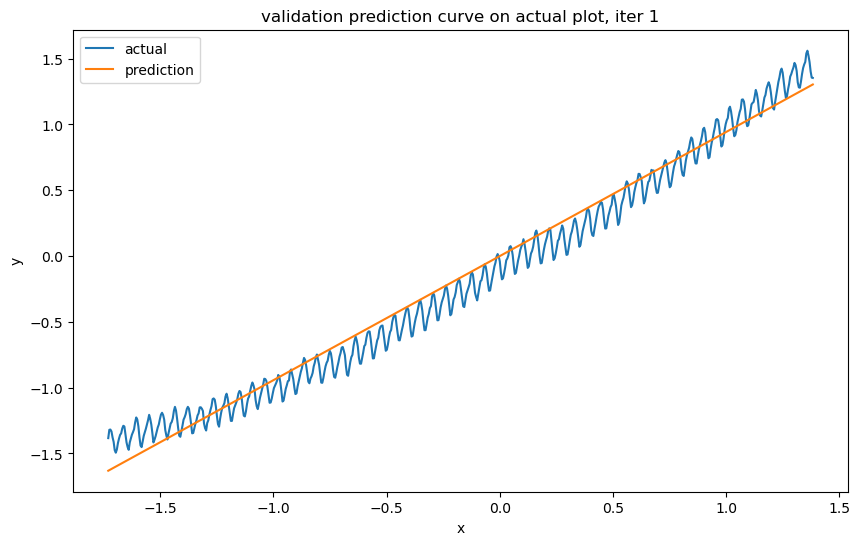

396.3936821473898
iteration 2


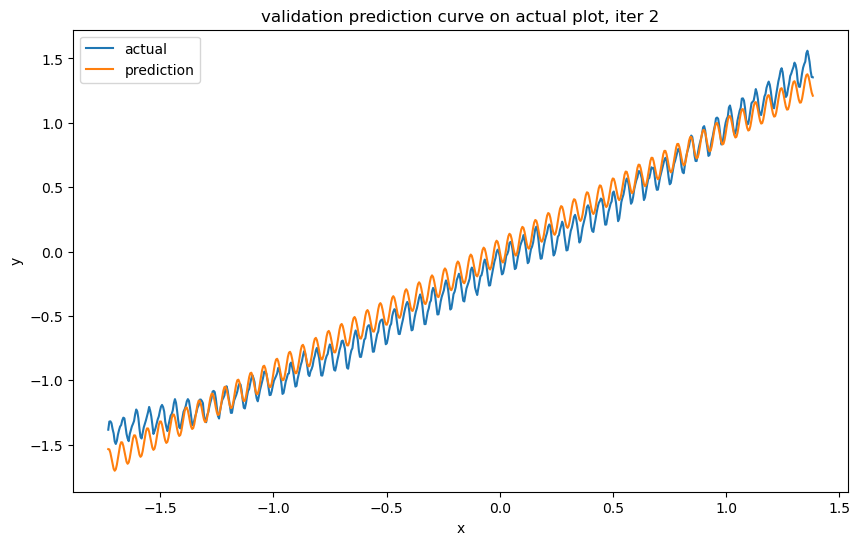

343.96191149410686
iteration 3


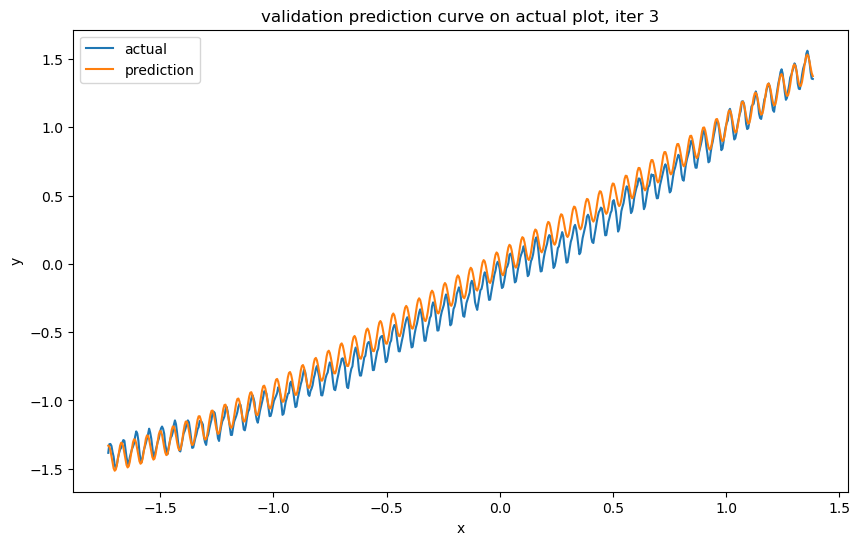

282.05558681699006
iteration 4


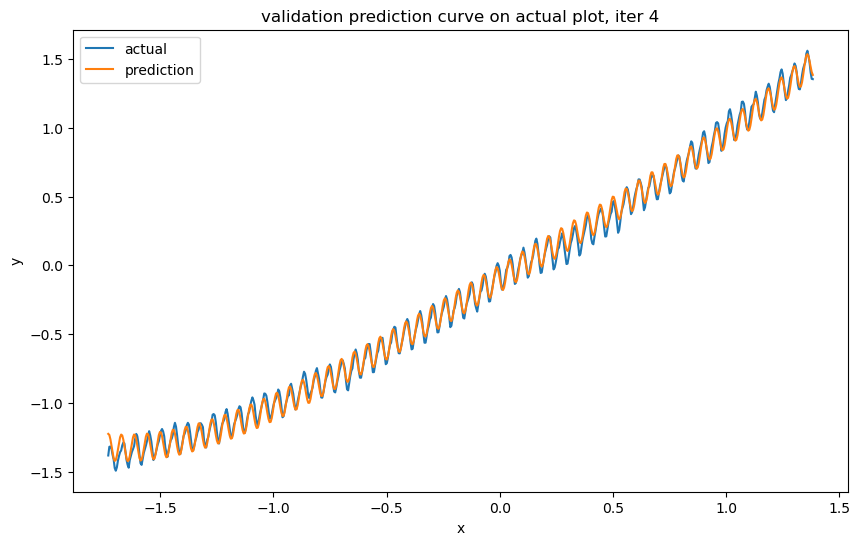

29.185908390953244
iteration 5


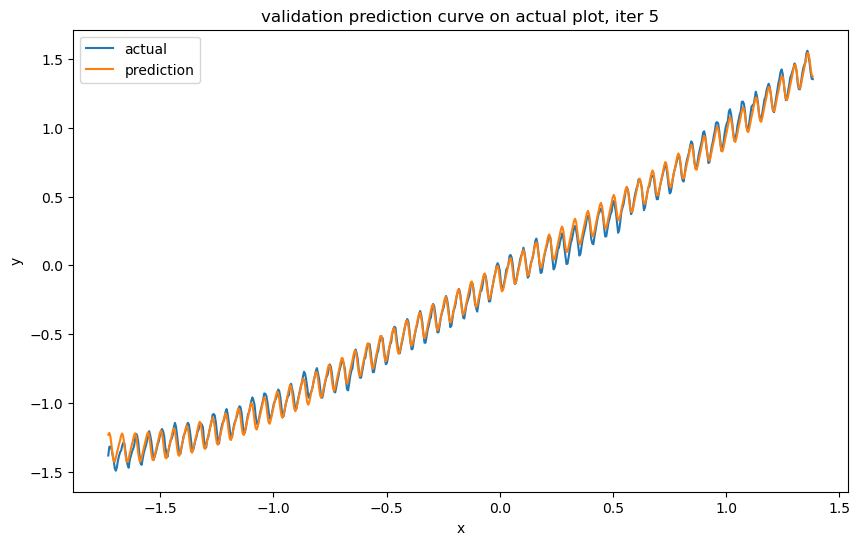

8.883834877866494
iteration 6


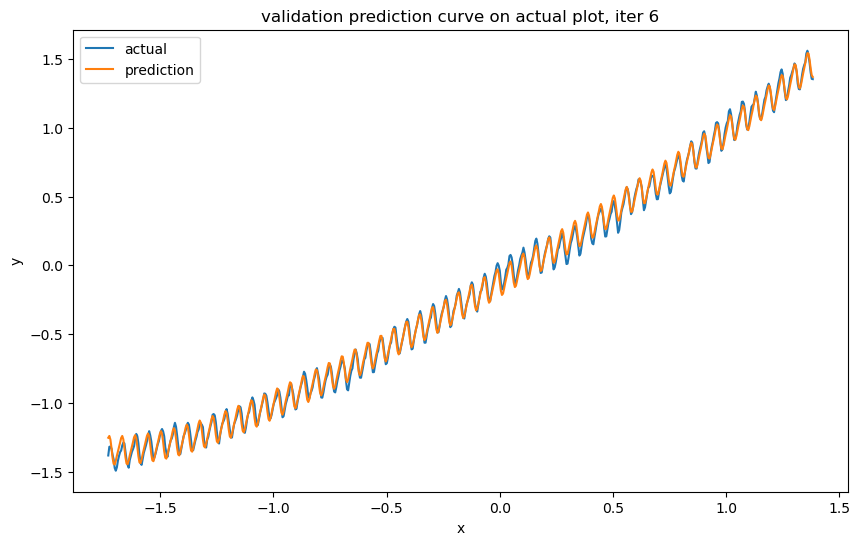

-17.33384531109329
iteration 7


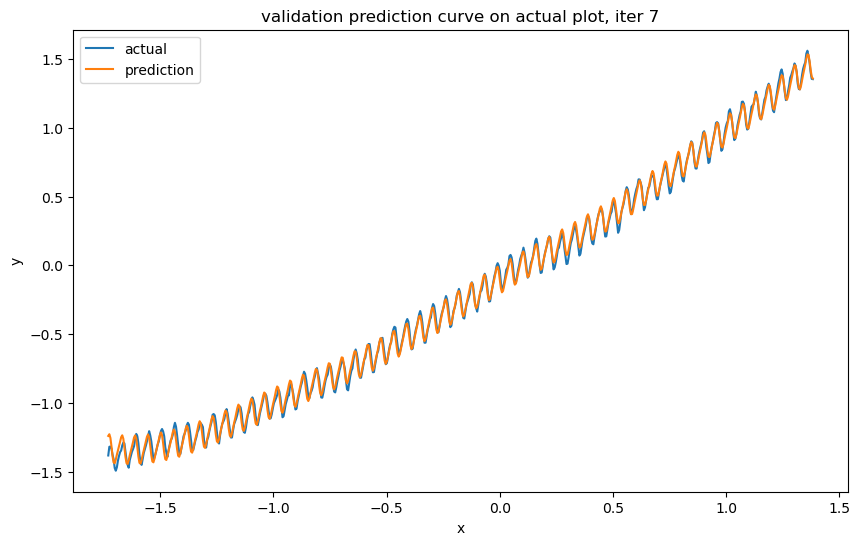

-31.548277727213623
iteration 8


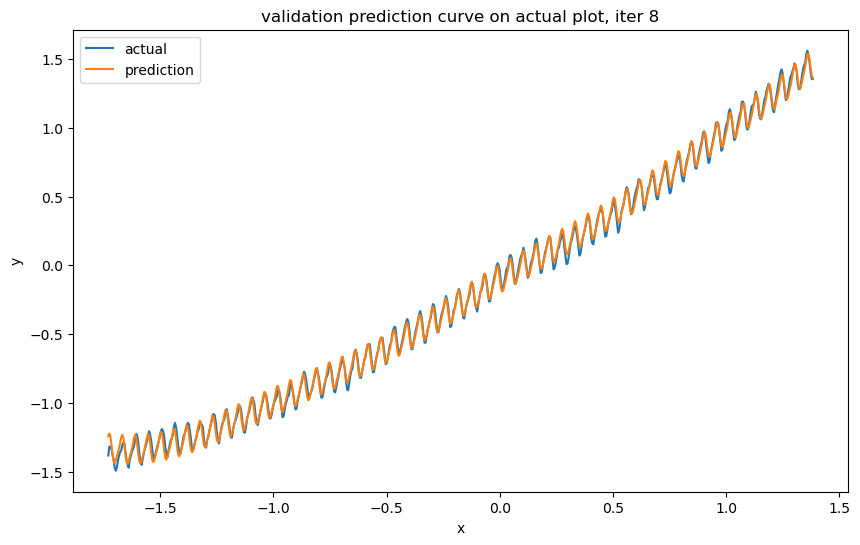

-42.87308315159091
iteration 9


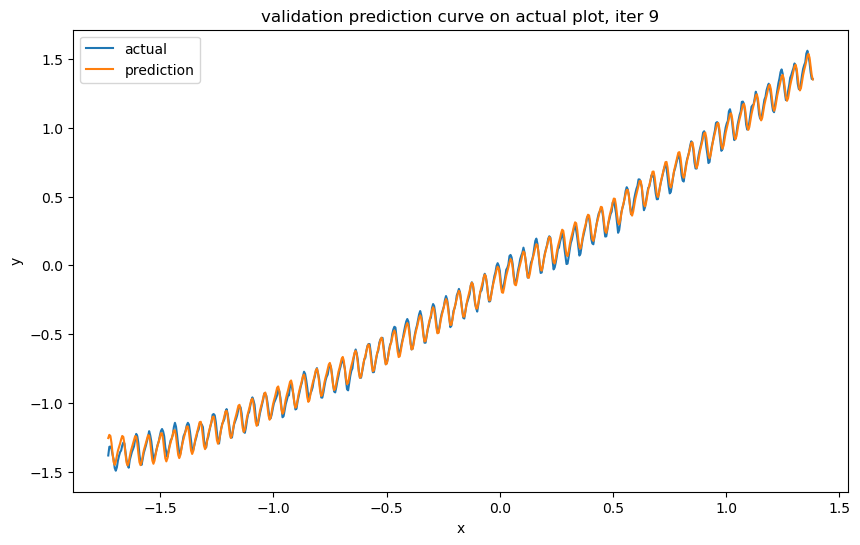

-55.11428983608641
iteration 10


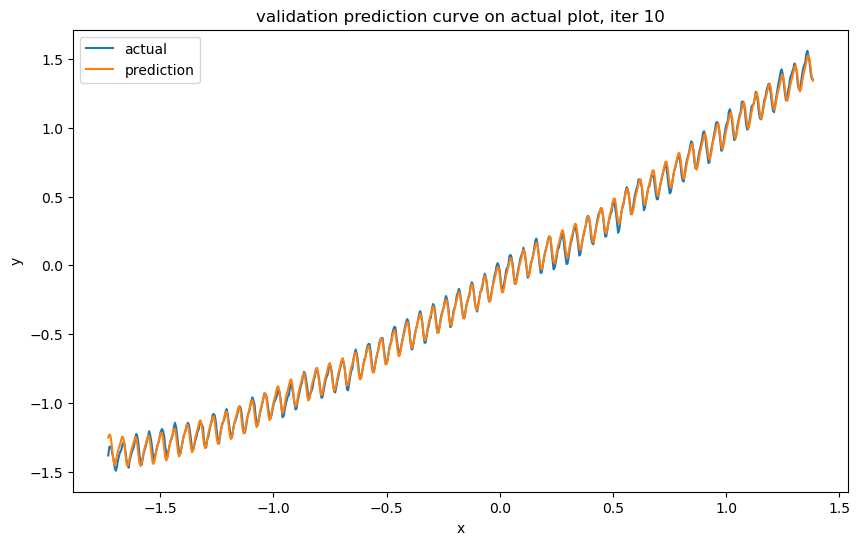

-63.479358379179864
iteration 11


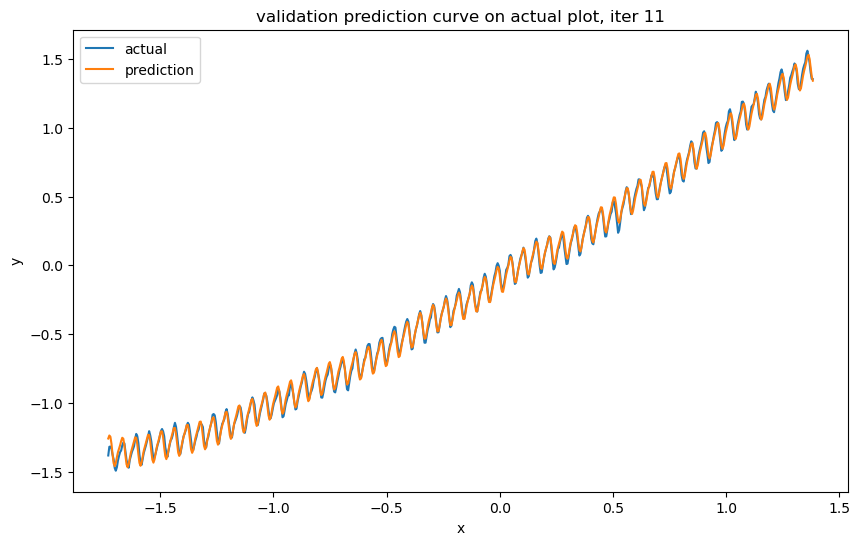

-70.60018717085671
iteration 12


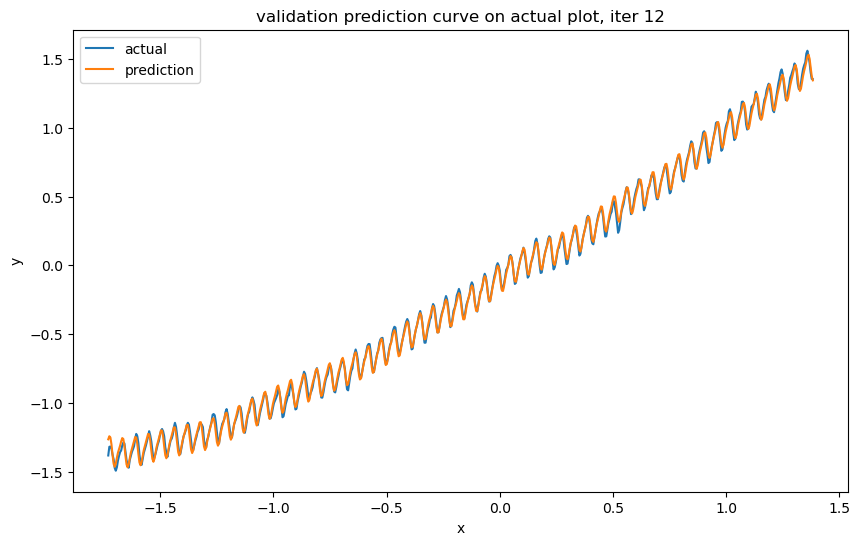

-72.87109169515271
iteration 13


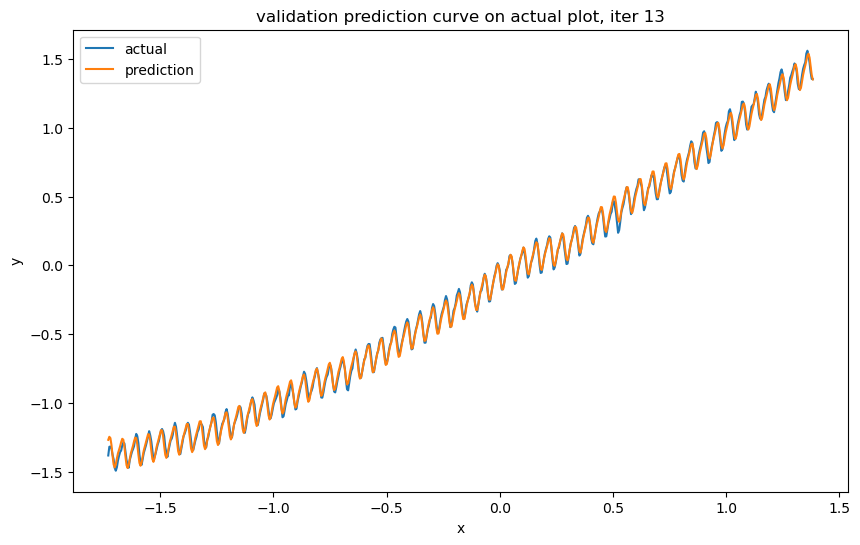

-75.8760866524665
iteration 14


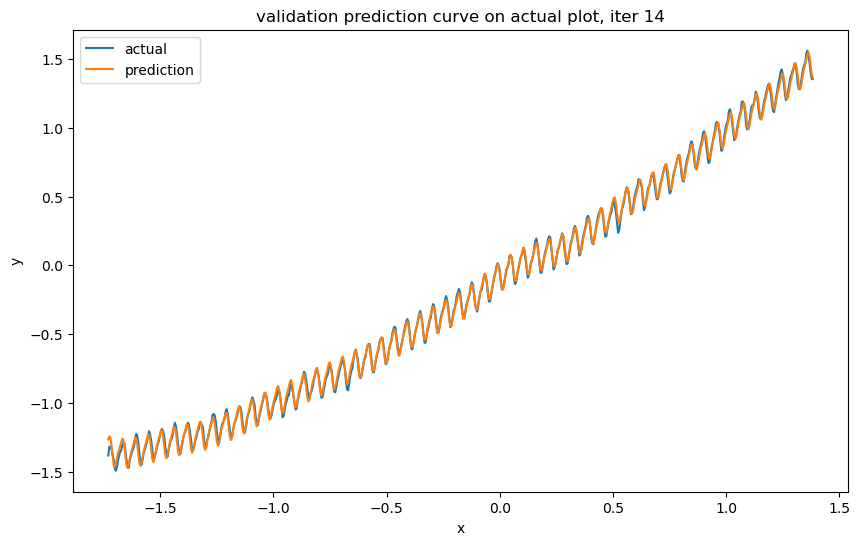

-78.19014434255732
iteration 15


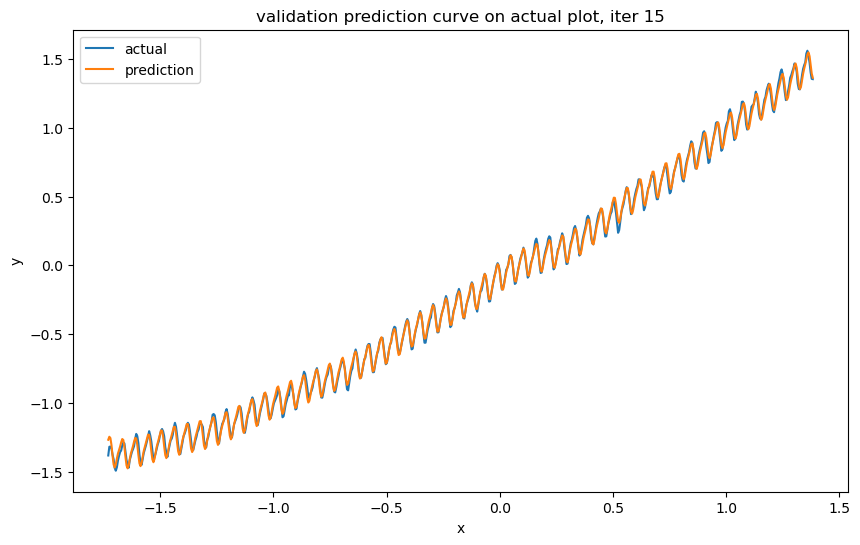

-82.1140353260472
iteration 16


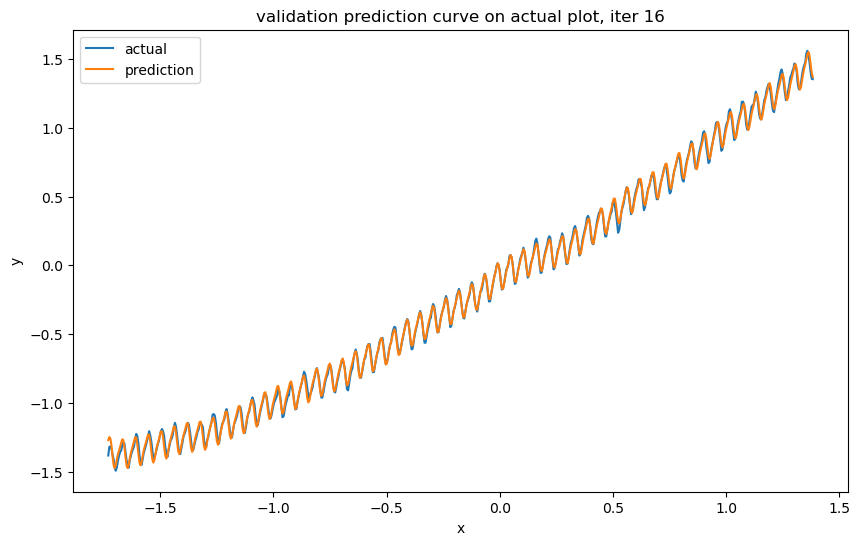

-83.03241461199526
iteration 17


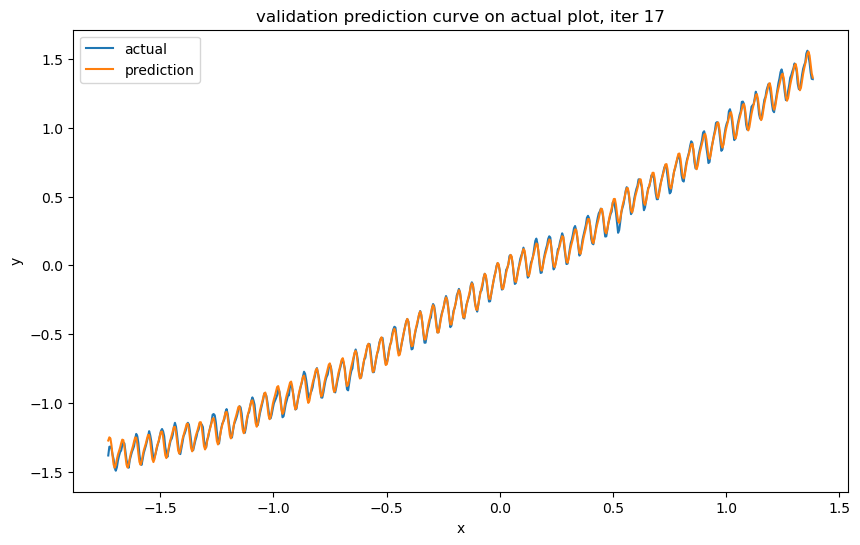

-82.20154788531539


In [6]:
# mauna loa set
# train model (greedy)

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
x_train = np.vstack([x_valid, x_train])
y_train = np.vstack([y_valid, y_train])

n = x_train.shape[0]
r = np.copy(y_train)
k = 0

selection = []
candidate = np.arange(0,len(D))
min_mdl   = np.inf              # initialize min mdl to sufficiently large
mdl       = -np.inf

print('starting...')
while candidate.shape[0]>0:

    k += 1
    print(f'iteration {k}')

    # metric for choosing new basis function
    J = []
    for i in candidate:
        phi_i = np.array(D[i](x_train))
        J    += [np.square(np.matmul(phi_i.T, r)) / np.abs(np.matmul(phi_i.T, phi_i))]

    i_max      = np.argmax(J)
    #print(i_max)
    selection += [candidate[i_max]]
    #print(selection)
    candidate  = np.delete(candidate, i_max)

    Phi_x = np.empty((n,k))
    for i, func in enumerate(selection):
        Phi_x[:,i] = D[func](x_train.T)

    U, s, Vt = scipy.linalg.svd(Phi_x, full_matrices=False)
    weights  = Vt.T.dot(U.T.dot(y_train) / np.reshape(s, (-1,1)))
    y_pred   = x_train.dot(weights.T)
    
    y_pred   = Phi_x.dot(weights)
    #print(y_pred)

    plt.figure(figsize=(10,6))
    plt.plot(x_train, y_train, label='actual')
    plt.plot(x_train, y_pred, label='prediction')
    plt.title(f'validation prediction curve on actual plot, iter {k}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best')
    plt.show()

    # update residual r
    r   = y_train - y_pred
    mdl = n/2 * np.log(np.sqrt(np.sum(np.square(r)))) + k/2 * np.log(n)
    print(mdl)
    # print(selection)
    # print(weights)

    if mdl < min_mdl:
        min_mdl = mdl
    else:
        break

selection = selection[:-1]
weights   = weights[:-1]

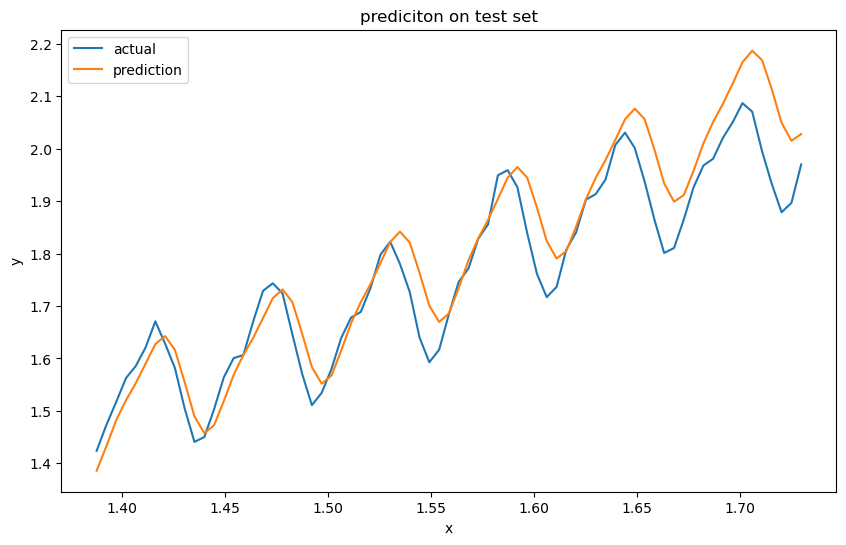

RMSE on test set = 0.06873858375899194


In [7]:
# test set

n         = x_test.shape[0]
Phi       = np.empty((n, len(selection)))

for i, func in enumerate(selection):
    Phi[:,i] = D[func](x_test.T)
y_pred = Phi.dot(weights)

plt.figure(figsize=(10,6))
plt.plot(x_test, y_test, label='actual')
plt.plot(x_test, y_pred, label='prediction')
plt.title('prediciton on test set')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

RMSE = np.sqrt(np.mean(np.square(y_test-y_pred)))
print(f'RMSE on test set = {RMSE}')